In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
#1.모듈로딩

In [10]:
batch_size=32
learning_rate=1e-4
epochs=100
 #2.하이퍼 파라미터

In [11]:
dir = Path.joinpath(list(Path.cwd().parents)[2], "00. DeepLearning/00_Dataset")
ds_train = torchvision.datasets.MNIST(root=dir, 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)
ds_test = torchvision.datasets.MNIST(root=dir, 
                                     train=False, 
                                     transform=transforms.ToTensor(),
                                     download=True)

dl_train=torch.utils.data.DataLoader(ds_train,batch_size,shuffle=True,drop_last=False)
dl_test=torch.utils.data.DataLoader(ds_test,batch_size,shuffle=True,drop_last=False)
#3.dataset정의

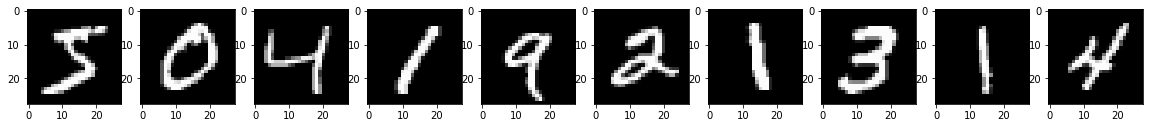

In [12]:
fig, axes = plt.subplots(1,10,figsize=(20, 2))
for i in range(10):
    img = ds_train[i][0]
    label = ds_train[i][1]
    axes[i].imshow(img.squeeze(), cmap='gray')

In [13]:
conv = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Flatten(),
)


input = torch.ones((1,1,28,28), dtype=torch.float32)
out = conv(input)
conv_out_size = torch.numel(out)
print(conv_out_size)

lin = nn.Sequential(
    nn.Linear(in_features=512, out_features=512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=512, out_features=10)
)

model = nn.Sequential(conv,lin)
out = model(input)

#4.NN정의

512


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def evaluate(data_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    model.train()
    return accuracy

In [15]:
import time
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_criterion = torch.nn.CrossEntropyLoss()
#6.opt & loss_criterion

model = model.to(device)

losses = []
accs = []
for epoch in range(epochs):
    start_time = time.time()
    loss_avg = 0
    for i, (imgs, targets) in enumerate(dl_train):
        imgs, targets = imgs.to(device), targets.to(device)
        out = model(imgs)
        loss = loss_criterion(out, targets)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_avg += loss.item()
    loss_avg = loss_avg / (i + 1)
    losses.append(loss_avg)
    end_time = time.time()
    epoch_time = end_time - start_time
    if (epoch+1)%10==0:
        acc=evaluate(dl_test)
        accs.append(acc)
        print(f"Epoch {epoch + 1}; acc: {acc:.4f}")
    print(f"Epoch {epoch + 1}; Loss: {loss_avg:.4f}; epoch_time:{epoch_time}")
#7.train & 8.evaluation

#batch size 64 : 349.7405948638916초 (5 분 49초)
#batch size 32 : 439.6768581867218초 (7 분 19초)

Epoch 1; Loss: 0.2995; epoch_time:439.6768581867218
Epoch 2; Loss: 0.0868; epoch_time:432.58649706840515
Epoch 3; Loss: 0.0570; epoch_time:432.1646490097046
Epoch 4; Loss: 0.0429; epoch_time:477.95132398605347
Epoch 5; Loss: 0.0323; epoch_time:493.6443657875061
Epoch 6; Loss: 0.0251; epoch_time:493.5661222934723
Epoch 7; Loss: 0.0203; epoch_time:544.6824312210083
Epoch 8; Loss: 0.0168; epoch_time:585.9261457920074
Epoch 9; Loss: 0.0143; epoch_time:410.4204819202423
Epoch 10; acc: 0.9890
Epoch 10; Loss: 0.0123; epoch_time:389.1360650062561
Epoch 11; Loss: 0.0108; epoch_time:386.207093000412
Epoch 12; Loss: 0.0083; epoch_time:385.2708637714386
Epoch 13; Loss: 0.0093; epoch_time:385.96719789505005
Epoch 14; Loss: 0.0083; epoch_time:384.76185512542725
Epoch 15; Loss: 0.0075; epoch_time:386.29380202293396
Epoch 16; Loss: 0.0058; epoch_time:384.7880482673645
Epoch 17; Loss: 0.0069; epoch_time:385.80061411857605
Epoch 18; Loss: 0.0047; epoch_time:384.13374495506287
Epoch 19; Loss: 0.0057; epo

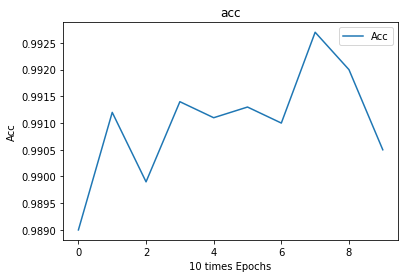

In [19]:
import matplotlib.pyplot as plt

plt.plot(accs, label='Acc')
plt.xlabel('10 Epochs')
plt.ylabel('Acc')
plt.title('acc')
plt.legend()
plt.show()

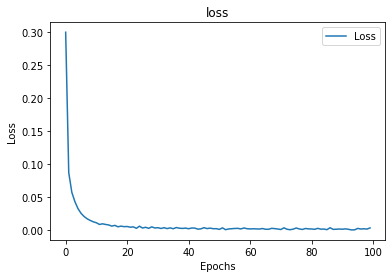

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('loss')
plt.legend()
plt.show()

In [21]:
def rev_norm(img): # -1 <= ig <= 1
    img = (img + 1)/2
    img = torch.clip(img, 0, 1)
    return img

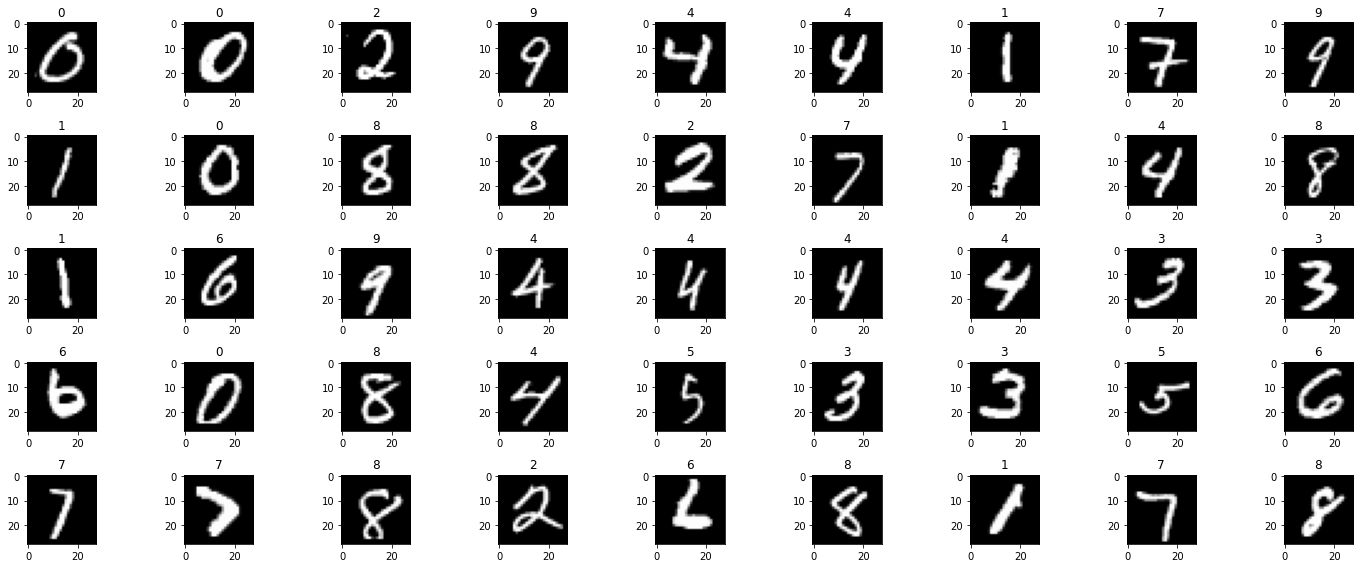

In [22]:
fig, axs = plt.subplots(5, 9, figsize=(20, 8))
i = 0
for imgs, labels in dl_train:
    for img, label in zip(imgs, labels):
        img = rev_norm(img)
        if i < 45:
            axs[i // 9, i % 9].imshow(img.reshape((28, 28)), cmap='gray')
            axs[i // 9, i % 9].set_title(label.item())
        else:
            break
        i += 1
        if i == 45:
            break

plt.tight_layout()
plt.show()
